In [1]:
import numpy as np
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import pandas as pd
def correlation_center_finder(grid1, grid2):
    def cycle_matrix(matrix, row_shift, col_shift):
        row_shift %= matrix.shape[0]
        col_shift %= matrix.shape[1]
        return np.roll(np.roll(matrix, row_shift, axis=0), col_shift, axis=1)
    def compare_matrices_ssim(matrix1, matrix2):
        data_range = max(Data_abv.max(), Data_blw.max()) - min(Data_abv.min(), Data_blw.min())
        return np.abs(ssim(matrix1, matrix2, data_range=data_range)) # Have |SSIM| it 
    def center_list(n):
        midpoint = n // 2
        return np.arange(-midpoint, n - midpoint)
    xs = center_list(grid1.shape[1])
    ys = center_list(grid1.shape[0])
    correlations = [
        (x, y, compare_matrices_ssim(grid1, cycle_matrix(grid2, y, x)))
        for x in xs for y in ys
    ]
    df = pd.DataFrame(correlations, columns=['Right', 'Up', 'Correlation'])
    best_shift = df.loc[df['Correlation'].idxmax()]
    return df, best_shift['Up'], best_shift['Right']
    
from shapely.geometry import Polygon
def calculate_centroid(xt, yt):
    if len(xt) == 0:
        return np.nan, np.nan
    polygon = Polygon(zip(xt, yt))
    centroid = polygon.centroid
    return centroid.x, centroid.y
    
def calculate_okubo_weis(uu, vv, dx, dy):
    WIDTH, LENGTH, SIGMAS = uu.shape
    u_x = (uu[2:,:,:] - uu[:-2,:,:]) / (2*dx)
    u_y = (uu[:,2:,:] - uu[:,:-2,:]) / (2*dy)
    v_x = (vv[2:,:,:] - vv[:-2,:,:]) / (2*dx)
    v_y = (vv[:,2:,:] - vv[:,:-2,:]) / (2*dy)
    u_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), u_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    v_x = np.concatenate((np.zeros((1, LENGTH, SIGMAS)), v_x, np.zeros((1, LENGTH, SIGMAS))), axis=0)
    u_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), u_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    v_y = np.concatenate((np.zeros((WIDTH, 1, SIGMAS)), v_y, np.zeros((WIDTH, 1, SIGMAS))), axis=1)
    s_n = u_x - v_y
    s_s = v_x + u_y
    vort = v_x - u_y
    ow = s_n**2 + s_s**2 - vort**2
    return ow
    
def normalize_matrix(LOW):
    ocean_mask = np.where(np.isnan(LOW), np.zeros_like(LOW), 1)
    OW_mean = np.nansum(LOW) / np.sum(ocean_mask)
    OW_std = np.sqrt(np.nansum(ocean_mask * (LOW - OW_mean) ** 2) / np.sum(ocean_mask))
    return LOW / OW_std

def make_cartesian(lon, lat, theta0, phi0):
    lonr, latr = np.deg2rad(lon), np.deg2rad(lat)
    r_earth = 6371
    x = r_earth * np.cos(np.deg2rad(phi0)) * (lonr - np.deg2rad(theta0))
    y = r_earth * (latr - np.deg2rad(phi0))
    return x, y

def make_ssim_matrix(df):
    xs, ys, values = df.Right, df.Up, df.Correlation
    ssim_mat = np.zeros((len(np.unique(xs)), len(np.unique(ys))))
    for i in np.unique(xs):
        for j in np.unique(ys):
            ssim_mat[i + np.unique(xs).min(), j + np.unique(ys).min()] = df.loc[(df['Right'] == i) & (df['Up'] == j), 'Correlation'].values[0]
    return ssim_mat

def gaussian_vortex(a, b, i_shift, j_shift, amplitude=1, sigma=1):
    x = np.linspace(-1, 1, b)
    y = np.linspace(-1, 1, a)
    x, y = np.meshgrid(x, y)
    return amplitude * np.exp(-((x - j_shift)**2 + (y - i_shift)**2) / (2 * sigma**2))

def annulus_vortex(a, b, inner_radius, outer_radius, i_shift, j_shift, amplitude=1, sigma=1):
    x = np.linspace(-1, 1, b)
    y = np.linspace(-1, 1, a)
    x, y = np.meshgrid(x, y)
    distance = np.sqrt((x - j_shift)**2 + (y - i_shift)**2)
    annulus = np.where((distance >= inner_radius) & (distance <= outer_radius),
                       amplitude * np.exp(-((distance)**2) / (2 * sigma**2)), 0)
    return annulus

def make_ssim_matrix(df):
    xs, ys, values = df.Right, df.Up, df.Correlation
    ssim_mat = np.zeros((len(np.unique(xs)), len(np.unique(ys))))
    for i in np.unique(xs):
        for j in np.unique(ys):
            ssim_mat[i + np.unique(xs).min(), j + np.unique(ys).min()] = df.loc[(df['Right'] == i) & (df['Up'] == j), 'Correlation'].values[0]
    return ssim_mat


## Tests

<function matplotlib.pyplot.show(close=None, block=None)>

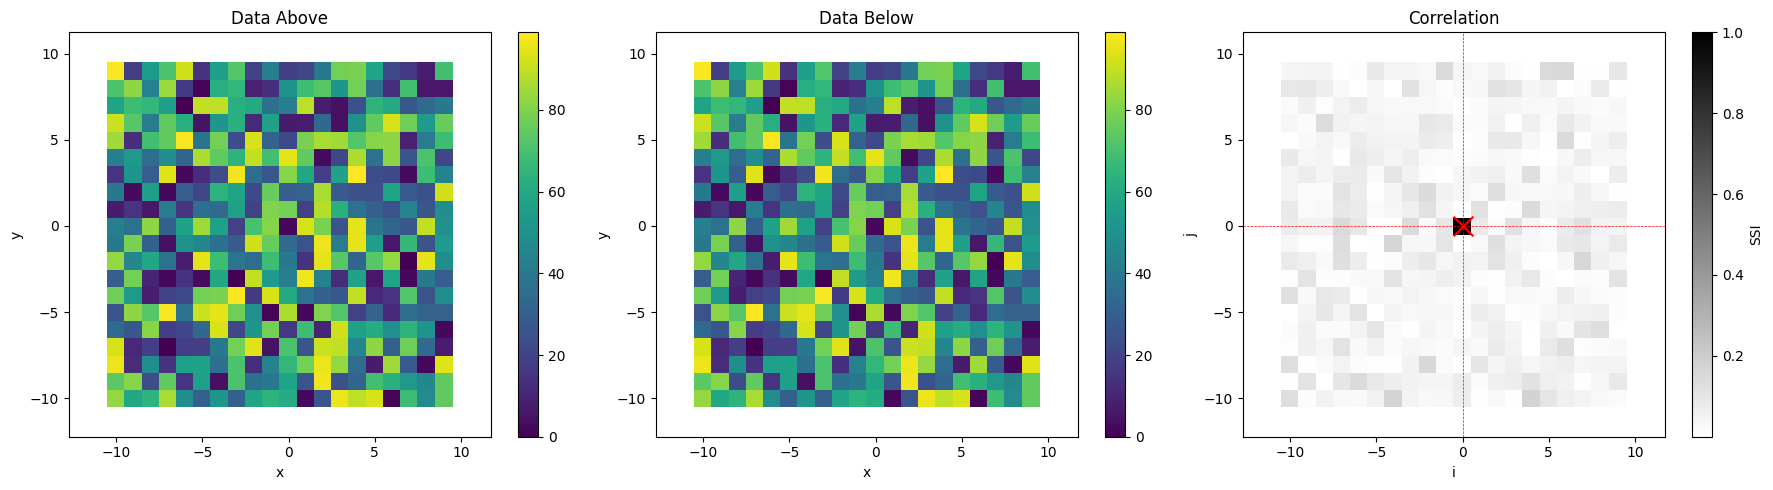

In [2]:
a, b = 20, 20

Data_abv = np.random.randint(0, 100, (a,b))
Data_blw = Data_abv

df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
ssim_mat = make_ssim_matrix(df)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# First subplot
contour1 = ax[0].pcolor(np.unique(df['Right']), np.unique(df['Up']), Data_abv)
ax[0].set_title('Data Above')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].axis('equal')

# Second subplot
contour2 = ax[1].pcolor(np.unique(df['Right']), np.unique(df['Up']), Data_blw)
ax[1].set_title('Data Below')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].axis('equal')

# Third subplot
contour3 = ax[2].pcolor(np.unique(df['Right']), np.unique(df['Up']), ssim_mat.T, cmap='gray_r')
ax[2].set_title('Correlation')
ax[2].scatter(iR, iU, marker='x', color='r', s=200)
ax[2].axvline(x=0, color='r', linestyle='--', linewidth=.5)  
ax[2].axhline(y=0, color='r', linestyle='--', linewidth=.5)  
ax[2].set_xlabel('i')
ax[2].set_ylabel('j')
ax[2].axis('equal')

cbar1 = fig.colorbar(contour1, ax=ax[0])
cbar2 = fig.colorbar(contour2, ax=ax[1])
cbar3 = fig.colorbar(contour3, ax=ax[2])
cbar3.set_label('SSI')

plt.tight_layout()
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

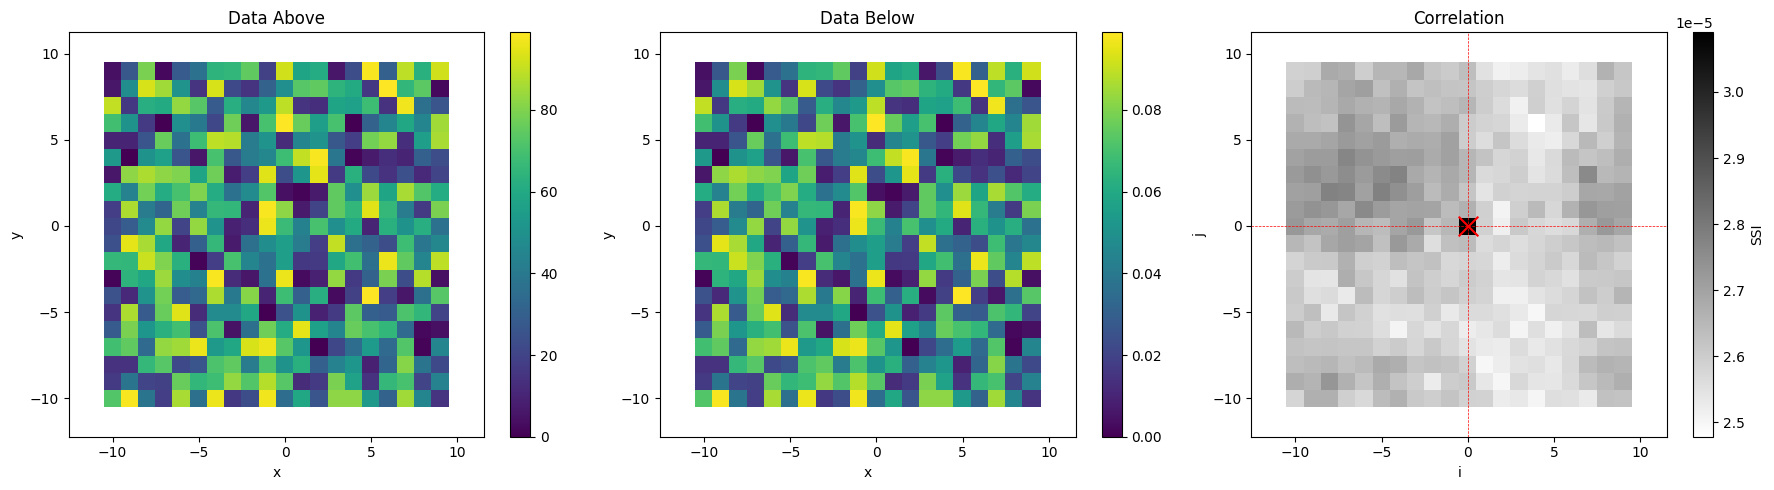

In [3]:
a, b = 20, 20

Data_abv = np.random.randint(0, 100, (a,b))
Data_blw = Data_abv / 1000

df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
ssim_mat = make_ssim_matrix(df)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# First subplot
contour1 = ax[0].pcolor(np.unique(df['Right']), np.unique(df['Up']), Data_abv)
ax[0].set_title('Data Above')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].axis('equal')

# Second subplot
contour2 = ax[1].pcolor(np.unique(df['Right']), np.unique(df['Up']), Data_blw)
ax[1].set_title('Data Below')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].axis('equal')

# Third subplot
contour3 = ax[2].pcolor(np.unique(df['Right']), np.unique(df['Up']), ssim_mat.T, cmap='gray_r')
ax[2].set_title('Correlation')
ax[2].scatter(iR, iU, marker='x', color='r', s=200)
ax[2].axvline(x=0, color='r', linestyle='--', linewidth=.5)  
ax[2].axhline(y=0, color='r', linestyle='--', linewidth=.5)  
ax[2].set_xlabel('i')
ax[2].set_ylabel('j')
ax[2].axis('equal')

cbar1 = fig.colorbar(contour1, ax=ax[0])
cbar2 = fig.colorbar(contour2, ax=ax[1])
cbar3 = fig.colorbar(contour3, ax=ax[2])
cbar3.set_label('SSI')

plt.tight_layout()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

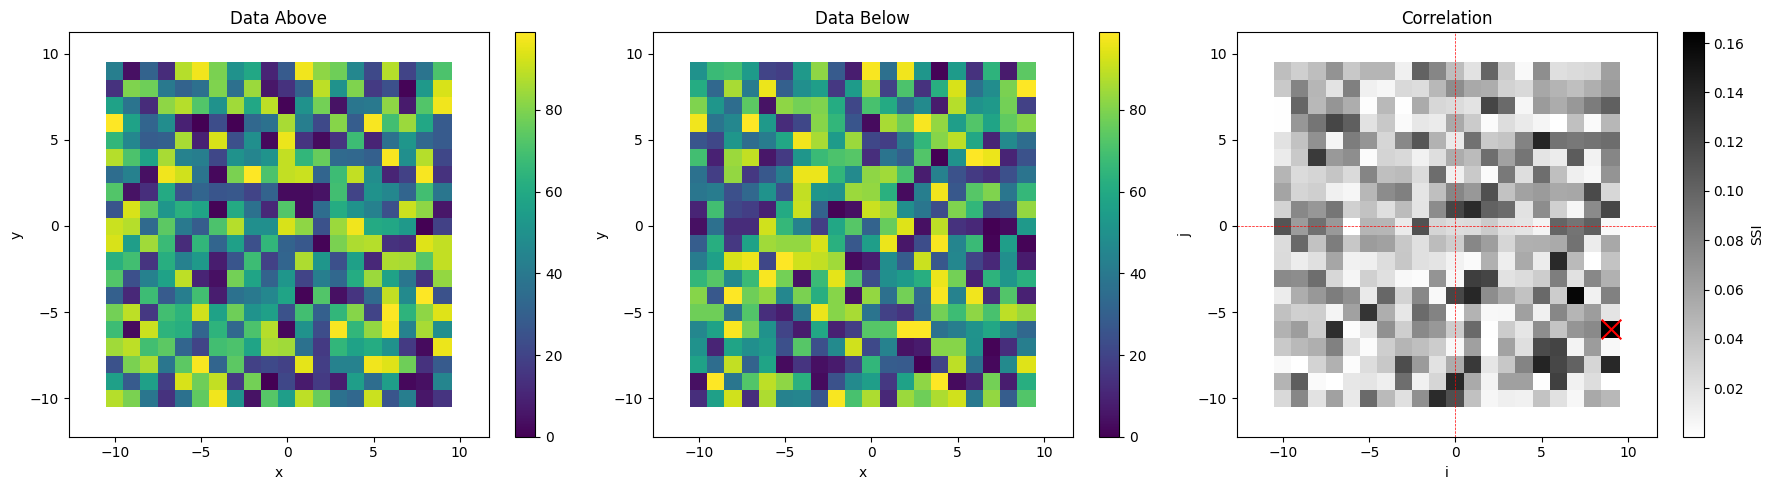

In [4]:
a, b = 20, 20

Data_abv = np.random.randint(0, 100, (a,b))
Data_blw = np.random.randint(0, 100, (a,b))

df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
ssim_mat = make_ssim_matrix(df)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# First subplot
contour1 = ax[0].pcolor(np.unique(df['Right']), np.unique(df['Up']), Data_abv)
ax[0].set_title('Data Above')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].axis('equal')

# Second subplot
contour2 = ax[1].pcolor(np.unique(df['Right']), np.unique(df['Up']), Data_blw)
ax[1].set_title('Data Below')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].axis('equal')

# Third subplot
contour3 = ax[2].pcolor(np.unique(df['Right']), np.unique(df['Up']), ssim_mat.T, cmap='gray_r')
ax[2].set_title('Correlation')
ax[2].scatter(iR, iU, marker='x', color='r', s=200)
ax[2].axvline(x=0, color='r', linestyle='--', linewidth=.5)  
ax[2].axhline(y=0, color='r', linestyle='--', linewidth=.5)  
ax[2].set_xlabel('i')
ax[2].set_ylabel('j')
ax[2].axis('equal')

cbar1 = fig.colorbar(contour1, ax=ax[0])
cbar2 = fig.colorbar(contour2, ax=ax[1])
cbar3 = fig.colorbar(contour3, ax=ax[2])
cbar3.set_label('SSI')

plt.tight_layout()
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

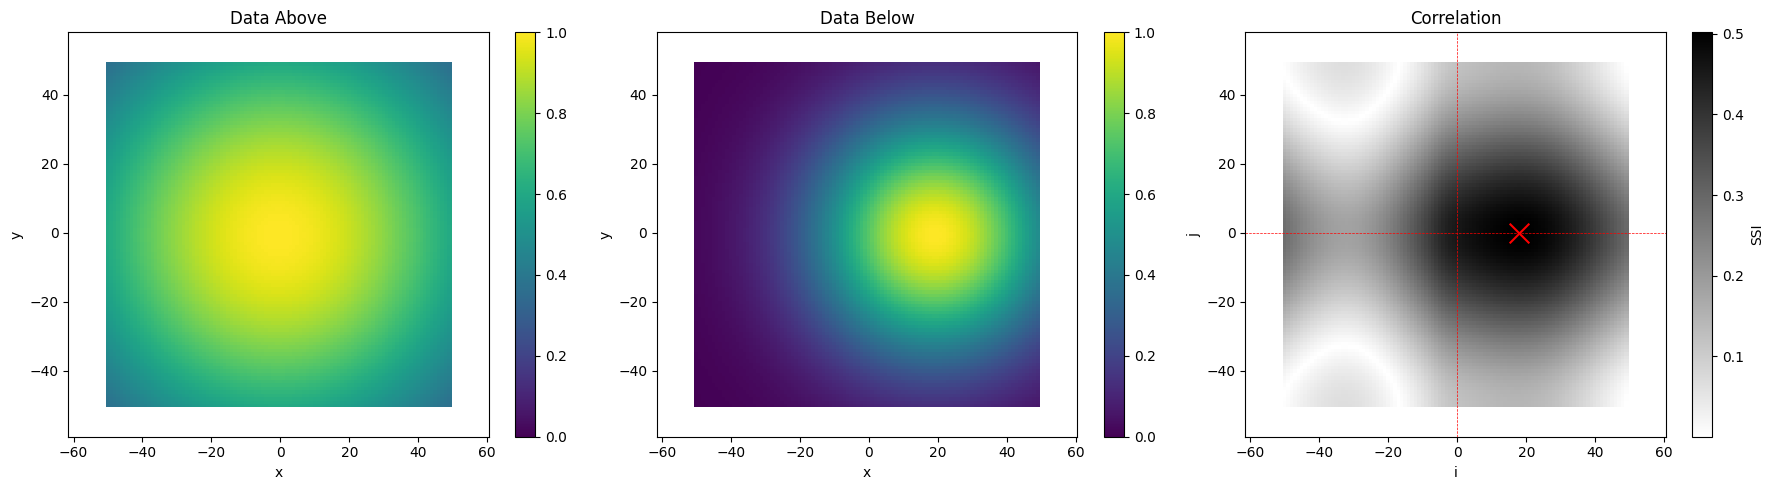

In [5]:
a, b = 100, 100
Data_abv = gaussian_vortex(a, b, 0, 0, amplitude=1, sigma=1)
Data_blw = gaussian_vortex(a, b, 0, .4, amplitude=1, sigma=.5)

df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
ssim_mat = make_ssim_matrix(df)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# First subplot
contour1 = ax[0].pcolor(np.unique(df['Right']), np.unique(df['Up']), Data_abv, vmin=0, vmax=1)
ax[0].set_title('Data Above')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].axis('equal')

# Second subplot
contour2 = ax[1].pcolor(np.unique(df['Right']), np.unique(df['Up']), Data_blw, vmin=0, vmax=1)
ax[1].set_title('Data Below')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].axis('equal')

# Third subplot
contour3 = ax[2].pcolor(np.unique(df['Right']), np.unique(df['Up']), ssim_mat.T, cmap='gray_r')
ax[2].set_title('Correlation')
ax[2].scatter(iR, iU, marker='x', color='r', s=200)
ax[2].axvline(x=0, color='r', linestyle='--', linewidth=.5)  
ax[2].axhline(y=0, color='r', linestyle='--', linewidth=.5)  
ax[2].set_xlabel('i')
ax[2].set_ylabel('j')
ax[2].axis('equal')

cbar1 = fig.colorbar(contour1, ax=ax[0])
cbar2 = fig.colorbar(contour2, ax=ax[1])
cbar3 = fig.colorbar(contour3, ax=ax[2])
cbar3.set_label('SSI')

plt.tight_layout()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

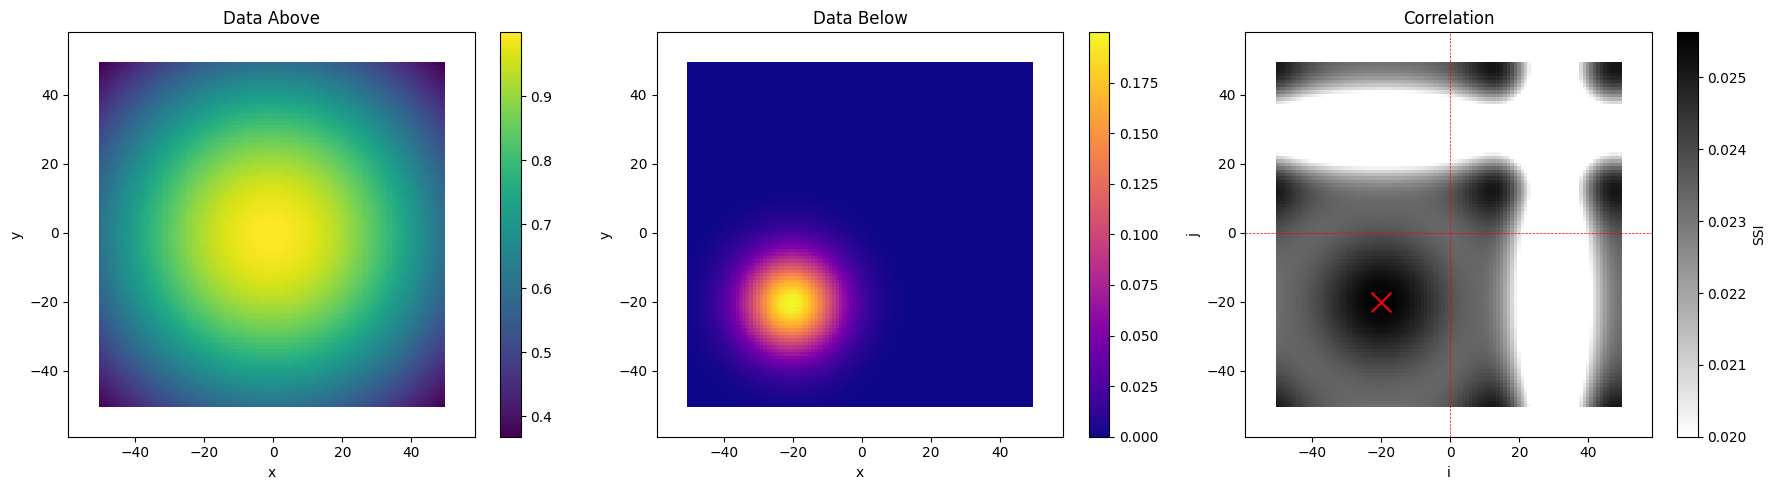

In [6]:
a, b = 100, 100
Data_abv = gaussian_vortex(a, b, 0, 0, amplitude=1, sigma=1)
Data_blw = gaussian_vortex(a, b, -.4, -.4, amplitude=.2, sigma=.2)

df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
ssim_mat = make_ssim_matrix(df)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# First subplot
contour1 = ax[0].pcolor(np.unique(df['Right']), np.unique(df['Up']), Data_abv)
ax[0].set_title('Data Above')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].axis('equal')

# Second subplot
contour2 = ax[1].pcolor(np.unique(df['Right']), np.unique(df['Up']), Data_blw, cmap='plasma')
ax[1].set_title('Data Below')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].axis('equal')

# Third subplot
contour3 = ax[2].pcolor(np.unique(df['Right']), np.unique(df['Up']), ssim_mat.T, cmap='gray_r', vmin=.02)
ax[2].set_title('Correlation')
ax[2].scatter(iR, iU, marker='x', color='r', s=200)
ax[2].axvline(x=0, color='r', linestyle='--', linewidth=.5)  
ax[2].axhline(y=0, color='r', linestyle='--', linewidth=.5)  
ax[2].set_xlabel('i')
ax[2].set_ylabel('j')
ax[2].axis('equal')

cbar1 = fig.colorbar(contour1, ax=ax[0])
cbar2 = fig.colorbar(contour2, ax=ax[1])
cbar3 = fig.colorbar(contour3, ax=ax[2])
cbar3.set_label('SSI')

plt.tight_layout()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

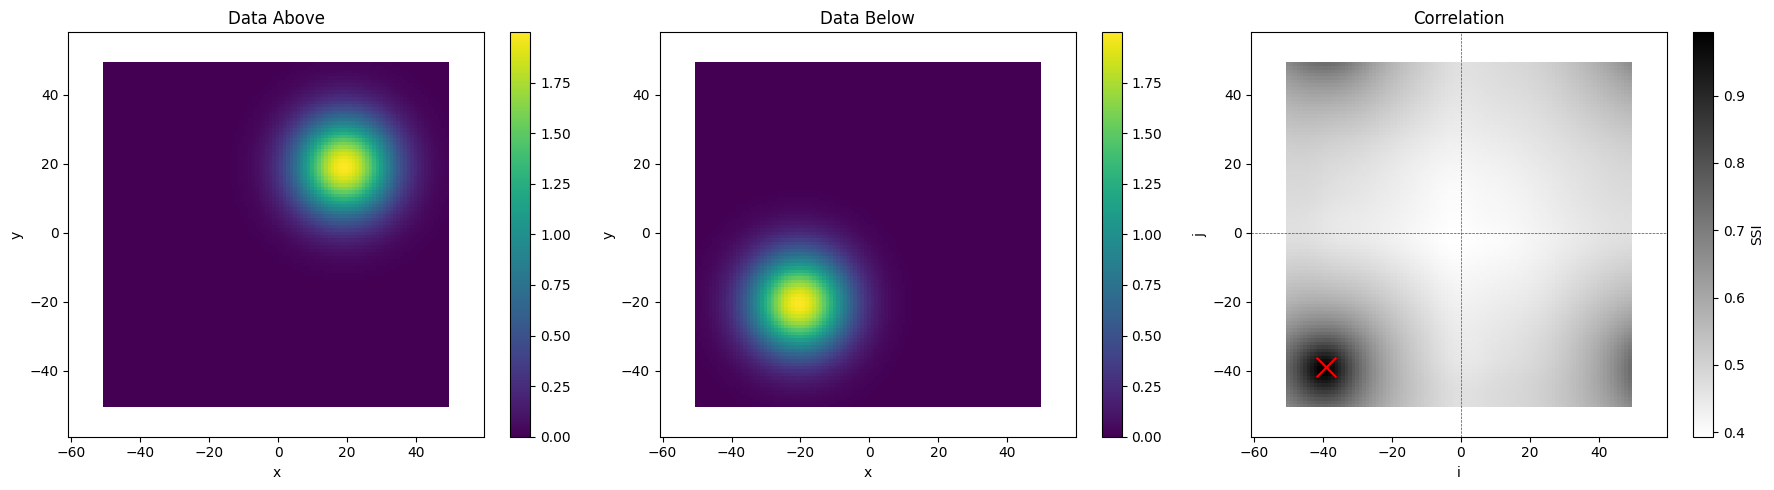

In [15]:
a, b = 100, 100
Data_abv = gaussian_vortex(a, b, .4, .4, amplitude=2, sigma=.2)
Data_blw = gaussian_vortex(a, b, -.4, -.4, amplitude=2, sigma=.2)

df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
ssim_mat = make_ssim_matrix(df)

x, y = np.unique(df['Right']), np.unique(df['Up'])

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# First subplot
contour1 = ax[0].pcolor(x, y, Data_abv)
ax[0].set_title('Data Above')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].axis('equal')

# Second subplot
contour2 = ax[1].pcolor(x, y, Data_blw)
ax[1].set_title('Data Below')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].axis('equal')

# Third subplot
contour3 = ax[2].pcolor(x, y, ssim_mat.T, cmap='gray_r')
ax[2].set_title('Correlation')
ax[2].scatter(iR, iU, marker='x', color='r', s=200)
ax[2].axvline(x=0, color='r', linestyle='--', linewidth=.5)  
ax[2].axhline(y=0, color='r', linestyle='--', linewidth=.5)  
ax[2].set_xlabel('i')
ax[2].set_ylabel('j')
ax[2].axis('equal')

cbar1 = fig.colorbar(contour1, ax=ax[0])
cbar2 = fig.colorbar(contour2, ax=ax[1])
cbar3 = fig.colorbar(contour3, ax=ax[2])
cbar3.set_label('SSI')

plt.tight_layout()
plt.show

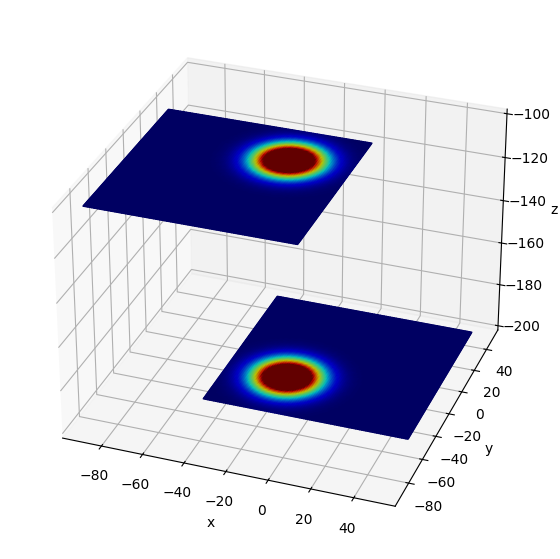

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


X, Y = np.meshgrid(x, y)

A, B = -100, -200

# Create 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot the first matrix Data_abv at z = -100
ax.plot_surface(X + iR, Y + iU, A * np.ones_like(X), rstride=1, cstride=1, facecolors=plt.cm.jet(Data_abv))

# Plot the second matrix Data_blw at z = -200
ax.plot_surface(X, Y, B * np.ones_like(X), rstride=1, cstride=1, facecolors=plt.cm.jet(Data_blw))

# ax.plot([iR, iR], [iU, iU], [-200, -100], linewidth=2, color='r')

# ax.quiver(0,0,-100,0,iU,-100)

ax.view_init(elev=30, azim=-70)


# Labels and title
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

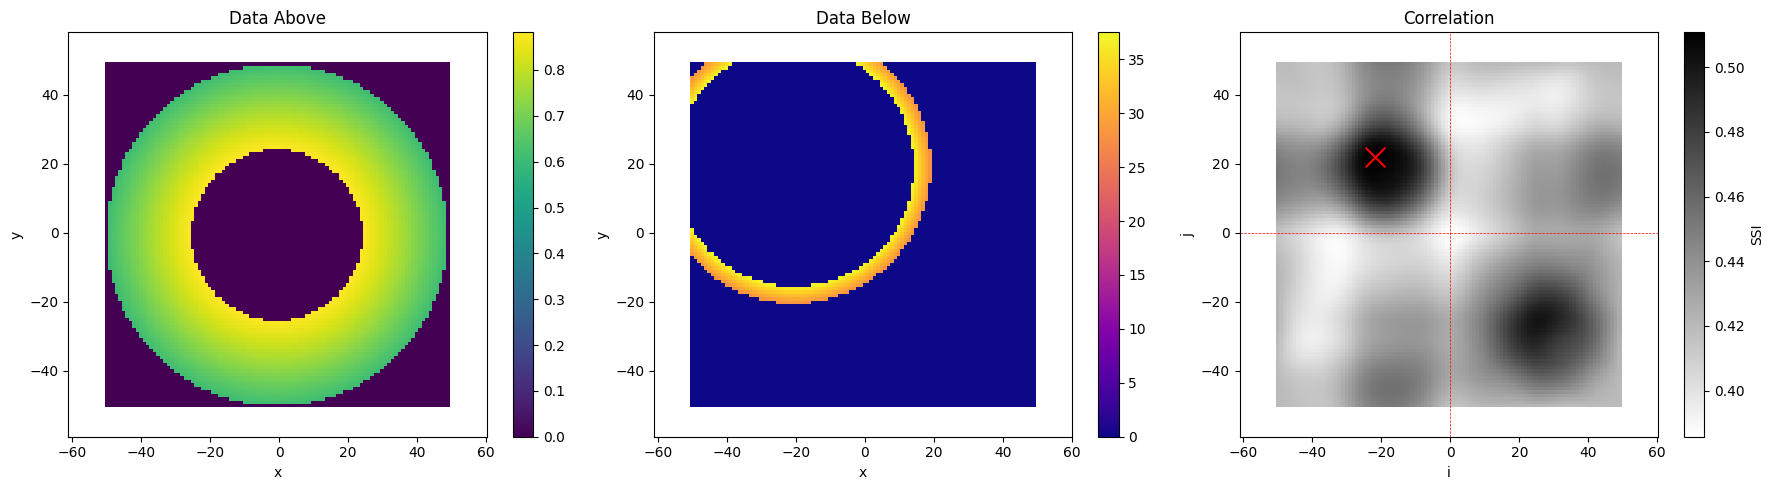

In [9]:
a, b = 100, 100
Data_abv = annulus_vortex(a, b, .5, 1, 0, 0, amplitude=1, sigma=1)
Data_blw = annulus_vortex(a, b, .7, .8, .4, -.4, amplitude=100, sigma=.5)

df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
ssim_mat = make_ssim_matrix(df)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# First subplot
contour1 = ax[0].pcolor(np.unique(df['Right']), np.unique(df['Up']), Data_abv)
ax[0].set_title('Data Above')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].axis('equal')

# Second subplot
contour2 = ax[1].pcolor(np.unique(df['Right']), np.unique(df['Up']), Data_blw, cmap='plasma')
ax[1].set_title('Data Below')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].axis('equal')

# Third subplot
contour3 = ax[2].pcolor(np.unique(df['Right']), np.unique(df['Up']), ssim_mat.T, cmap='gray_r')
ax[2].set_title('Correlation')
ax[2].scatter(iR, iU, marker='x', color='r', s=200)
ax[2].axvline(x=0, color='r', linestyle='--', linewidth=.5)  
ax[2].axhline(y=0, color='r', linestyle='--', linewidth=.5)  
ax[2].set_xlabel('i')
ax[2].set_ylabel('j')
ax[2].axis('equal')

cbar1 = fig.colorbar(contour1, ax=ax[0])
cbar2 = fig.colorbar(contour2, ax=ax[1])
cbar3 = fig.colorbar(contour3, ax=ax[2])
cbar3.set_label('SSI')

plt.tight_layout()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

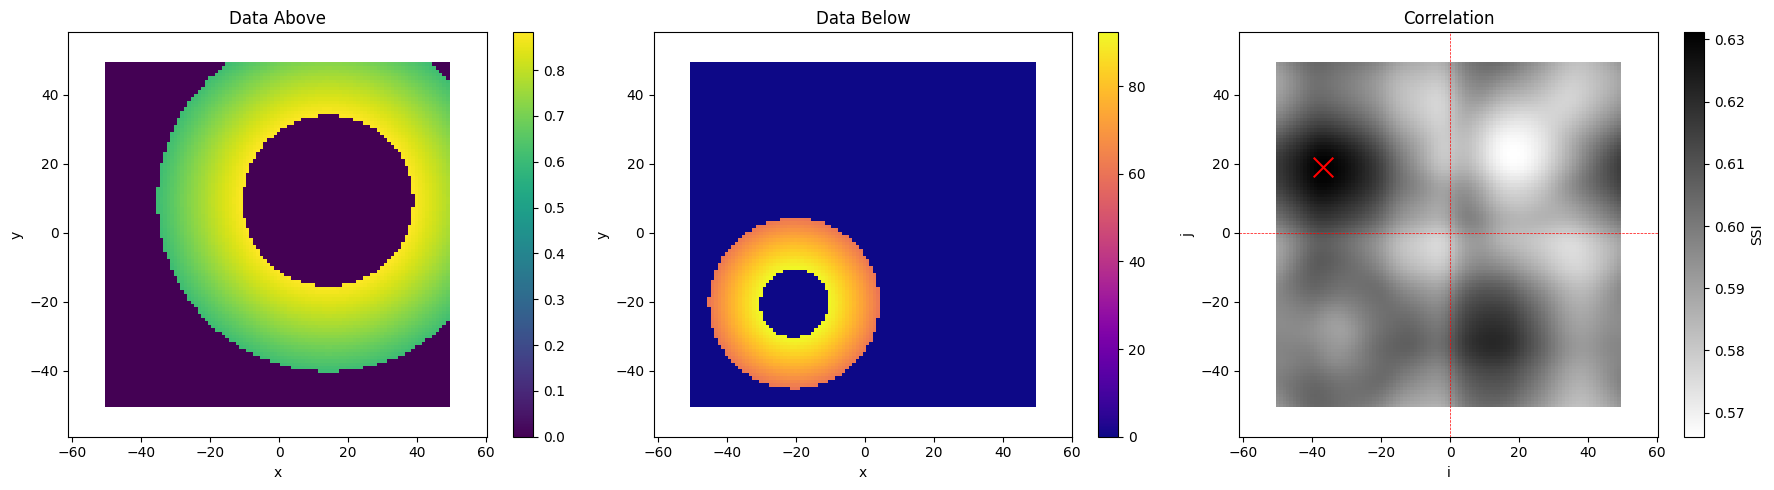

In [10]:
a, b = 100, 100
Data_abv = annulus_vortex(a, b, .5, 1, .2, .3, amplitude=1, sigma=1) #(a, b, in_r, out_r,...
Data_blw = annulus_vortex(a, b, .2, .5, -.4, -.4, amplitude=100, sigma=.5)

df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
ssim_mat = make_ssim_matrix(df)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# First subplot
contour1 = ax[0].pcolor(np.unique(df['Right']), np.unique(df['Up']), Data_abv)
ax[0].set_title('Data Above')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].axis('equal')

# Second subplot
contour2 = ax[1].pcolor(np.unique(df['Right']), np.unique(df['Up']), Data_blw, cmap='plasma')
ax[1].set_title('Data Below')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].axis('equal')

# Third subplot
contour3 = ax[2].pcolor(np.unique(df['Right']), np.unique(df['Up']), ssim_mat.T, cmap='gray_r')
ax[2].set_title('Correlation')
ax[2].scatter(iR, iU, marker='x', color='r', s=200)
ax[2].axvline(x=0, color='r', linestyle='--', linewidth=.5)  
ax[2].axhline(y=0, color='r', linestyle='--', linewidth=.5)  
ax[2].set_xlabel('i')
ax[2].set_ylabel('j')
ax[2].axis('equal')

cbar1 = fig.colorbar(contour1, ax=ax[0])
cbar2 = fig.colorbar(contour2, ax=ax[1])
cbar3 = fig.colorbar(contour3, ax=ax[2])
cbar3.set_label('SSI')

plt.tight_layout()
plt.show

Problem! Cyclic shift of 'Above' data makes the algorithm `cheat' and take a shortcut. 


<function matplotlib.pyplot.show(close=None, block=None)>

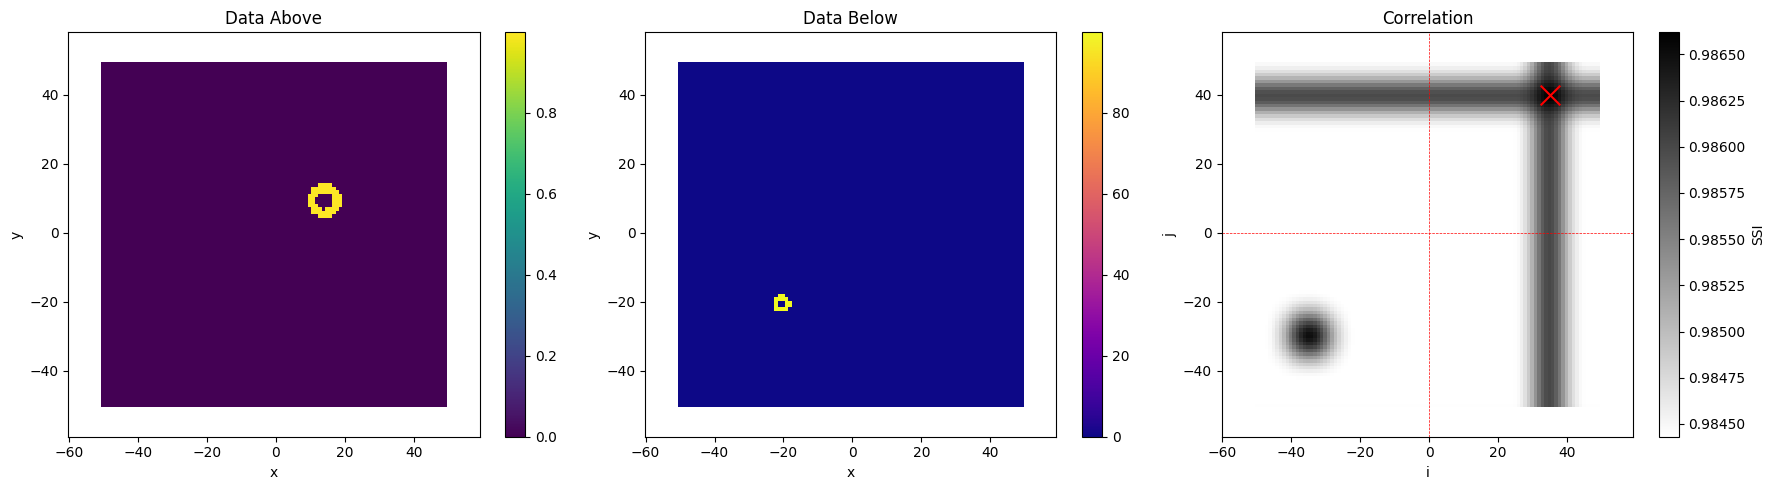

In [11]:
a, b = 100, 100

scalar = .1

Data_abv = annulus_vortex(a, b, .5*scalar, 1*scalar, .2, .3, amplitude=1, sigma=1) #(a, b, in_r, out_r,...
Data_blw = annulus_vortex(a, b, .2*scalar, .5*scalar, -.4, -.4, amplitude=100, sigma=.5)

df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
ssim_mat = make_ssim_matrix(df)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# First subplot
contour1 = ax[0].pcolor(np.unique(df['Right']), np.unique(df['Up']), Data_abv)
ax[0].set_title('Data Above')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].axis('equal')

# Second subplot
contour2 = ax[1].pcolor(np.unique(df['Right']), np.unique(df['Up']), Data_blw, cmap='plasma')
ax[1].set_title('Data Below')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].axis('equal')

# Third subplot
contour3 = ax[2].pcolor(np.unique(df['Right']), np.unique(df['Up']), ssim_mat.T, cmap='gray_r')
ax[2].set_title('Correlation')
ax[2].scatter(iR, iU, marker='x', color='r', s=200)
ax[2].axvline(x=0, color='r', linestyle='--', linewidth=.5)  
ax[2].axhline(y=0, color='r', linestyle='--', linewidth=.5)  
ax[2].set_xlabel('i')
ax[2].set_ylabel('j')
ax[2].axis('equal')

cbar1 = fig.colorbar(contour1, ax=ax[0])
cbar2 = fig.colorbar(contour2, ax=ax[1])
cbar3 = fig.colorbar(contour3, ax=ax[2])
cbar3.set_label('SSI')

plt.tight_layout()
plt.show

Problem! Again, algorithm is abusing cyclic shift and taking shortcut. 

<function matplotlib.pyplot.show(close=None, block=None)>

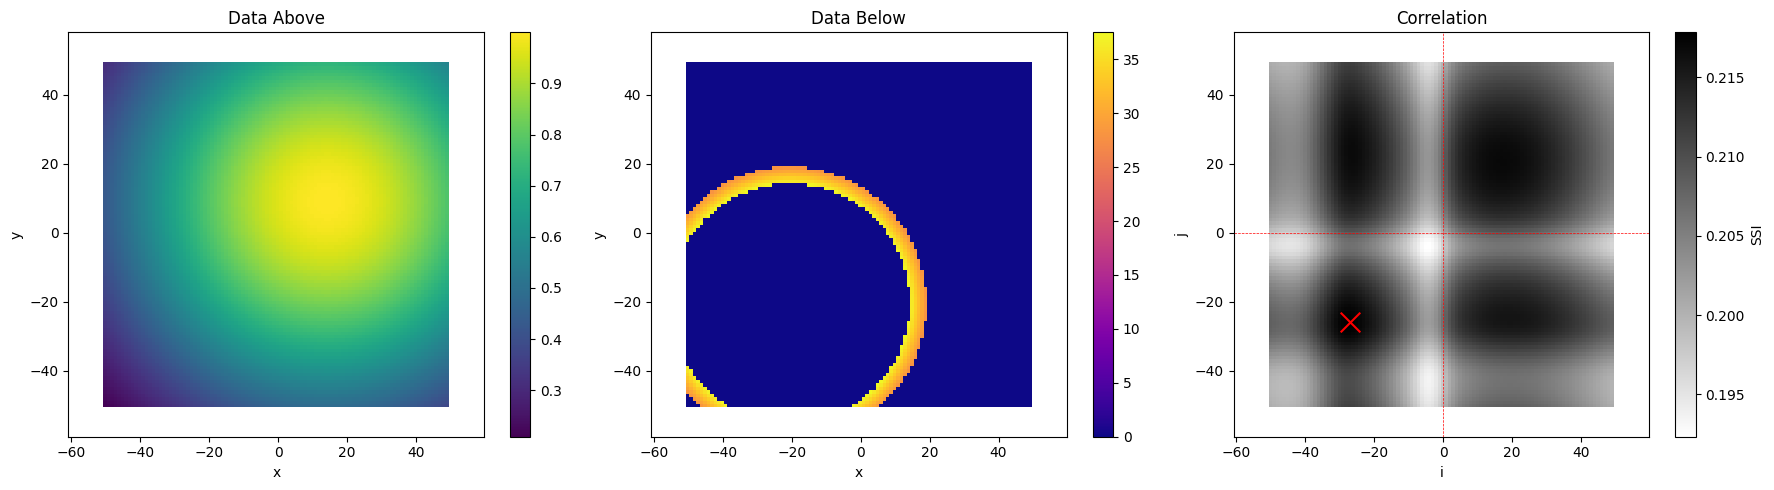

In [12]:
a, b = 100, 100
Data_abv = gaussian_vortex(a, b, .2, .3, amplitude=1, sigma=1)
Data_blw = annulus_vortex(a, b, .7, .8, -.4, -.4, amplitude=100, sigma=.5)

df, iU, iR = correlation_center_finder(Data_blw, Data_abv)
ssim_mat = make_ssim_matrix(df)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# First subplot
contour1 = ax[0].pcolor(np.unique(df['Right']), np.unique(df['Up']), Data_abv)
ax[0].set_title('Data Above')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].axis('equal')

# Second subplot
contour2 = ax[1].pcolor(np.unique(df['Right']), np.unique(df['Up']), Data_blw, cmap='plasma')
ax[1].set_title('Data Below')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].axis('equal')

# Third subplot
contour3 = ax[2].pcolor(np.unique(df['Right']), np.unique(df['Up']), ssim_mat.T, cmap='gray_r')
ax[2].set_title('Correlation')
ax[2].scatter(iR, iU, marker='x', color='r', s=200)
ax[2].axvline(x=0, color='r', linestyle='--', linewidth=.5)  
ax[2].axhline(y=0, color='r', linestyle='--', linewidth=.5)  
ax[2].set_xlabel('i')
ax[2].set_ylabel('j')
ax[2].axis('equal')

cbar1 = fig.colorbar(contour1, ax=ax[0])
cbar2 = fig.colorbar(contour2, ax=ax[1])
cbar3 = fig.colorbar(contour3, ax=ax[2])
cbar3.set_label('SSI')

plt.tight_layout()
plt.show